In [ ]:
!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle
#!chmod 600 ~/.kaggle/kaggle.json
!cp /content/'kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API for fetching data to Kaggle :
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 99% 487M/493M [00:03<00:00, 211MB/s]
100% 493M/493M [00:03<00:00, 148MB/s]


In [ ]:
from zipfile import ZipFile
Amazonedata = '/content/amazonreviews.zip'
with ZipFile(Amazonedata, 'r') as zip:
  zip.extractall()
  print('Amazone data has been extracted')

Amazone data has been extracted


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
# Importing dependency :
import pandas as pd
import tensorflow as tf
import re
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Embedding
import numpy as np
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt



In [ ]:
import bz2
# Specify the path to the compressed file
compressed_file_path = '/content/train.ft.txt.bz2'

# Decompress the file and read its content
with bz2.open(compressed_file_path, 'rt', encoding='ISO-8859-1') as f:
    lines = f.readlines()

# Parse the lines and create a list of dictionaries
data = []
for line in lines:
    parts = line.strip().split(' ', 1)  # Split into label and text, with a maximum of 1 split
    label = parts[0].replace('__label__', '')  # Remove the prefix '__label__'
    text = parts[1]
    data.append({'label': label, 'text': text})

# Create a DataFrame from the list of dictionaries
Amazone_train = pd.DataFrame(data)

# Display the DataFrame
print(Amazone_train.head())

  label                                               text
0     2  Stuning even for the non-gamer: This sound tra...
1     2  The best soundtrack ever to anything.: I'm rea...
2     2  Amazing!: This soundtrack is my favorite music...
3     2  Excellent Soundtrack: I truly like this soundt...
4     2  Remember, Pull Your Jaw Off The Floor After He...


In [ ]:
Amazone_train_short = Amazone_train.head(100000)
print(Amazone_train_short.shape)

(100000, 2)


In [ ]:
# Convert label values from strings to integers and subtract 1
Amazone_train_short['label'] = Amazone_train_short['label'].astype(int) - 1

# Update the 'label' column in the DataFrame with the modified values
Amazone_train_short['label'] = Amazone_train_short['label'].values


<ipython-input-7-6a109cd72877>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train_short['label'] = Amazone_train_short['label'].astype(int) - 1
<ipython-input-7-6a109cd72877>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train_short['label'] = Amazone_train_short['label'].values


#### starting to connect from here

# Creating dataset for Tranformer model

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Amazone_train_short['text'].values, Amazone_train_short['label'].values))
# Check the element_spec of the dataset
print(dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [ ]:
print(dataset.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# Data processing for tranformer
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [ ]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
for text,label in dataset.take(2):
  print(text)
  print(label)

tf.Tensor(b'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would

In [ ]:
# Adapt the vectorize_layer to the training data
training_data=dataset.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
def vectorizer(text,label):
    return vectorize_layer(text),label

In [ ]:
train_dataset=dataset.map(vectorizer)

# Splitting data for tranformer

In [ ]:
validation_percentage = 0.2
# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_percentage)
# Take the first validation_size samples for validation
test_dataset = train_dataset.take(validation_size)
# Skip the validation_size samples and take the rest for training
train_dataset = train_dataset.skip(validation_size)


In [ ]:
vectorize_layer.get_vocabulary()[411]

'reader'

In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[ 230   46   57    1    5   21   40   11   22 1013    5  102  547   13
    2  230    1    1  732   20    2  145    7 1580    1    2   17   20
    1   14 1010  639    3    1  526    2  916    7    1    1 5415    1
 3019  359   13   14  113    1   43 3123   50    1    3    1  897 6093
  106    4 4317   19    1    6    1    2 1521    8   44  423   13    1
 1316    4   17    1  620   43   28  282  148    9  230   46   57    1
 2372   19   47   56   46 5241    2  932   28   71   11    2  487   13
    5   63  111  166    2  909 1521   62 1333  259   43   92  811  687
   39    9  230    7  639 3580  461  138   23  932   59   10    4 1085
   16  291   10    1    9   10   48    2    1  431   10   12    6 2058
   66  200  932  115    2    1    7  332   13   44 3369   15   39 5703
   34  680    3  162    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
# Creating training and testing dataset using batching and prefetch methods
BATCH_SIZE = 32
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Words embedding for Tranformer

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config

In [ ]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])
emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

In [ ]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)

(1, 8, 256)


In [ ]:
# Setting parameters:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=10

In [ ]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128  # Adjusted to match your setting
BATCH_SIZE = 32
D_FF = 1024
NUM_HEADS = 8
NUM_LAYERS = 1
NUM_EPOCHS = 10


# Building tranformer model

In [ ]:
encoder_input=Input(shape=(None,), dtype="int64", name="input")
x = Embeddings(SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_input)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)

x = Flatten()(x)
output=Dense(1, activation="sigmoid")(x)

transformer = tf.keras.Model(
    encoder_input, output, name="transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embeddings_4 (Embeddings)   (None, 250, 128)          1280000   
                                                                 
 transformer_encoder_4 (Tra  (None, 250, 128)          791296    
 nsformerEncoder)                                                
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_12 (Dense)            (None, 1)                 32001     
                                                                 
Total params: 2103297 (8.02 MB)
Trainable params: 2103297 (8.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# compiling tranformer model
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Training tranformer model through 10 epochs
history=transformer.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
2813/2813 [==============================] - 147s 49ms/step - loss: 0.7391 - accuracy: 0.5309 - val_loss: 0.6930 - val_accuracy: 0.5334
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2813/2813 [==============================] - 106s 37ms/step - loss: 0.5151 - accuracy: 0.7196 - val_loss: 0.3162 - val_accuracy: 0.8675
Epoch 3/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.2771 - accuracy: 0.8843 - val_loss: 0.2560 - val_accuracy: 0.8964
Epoch 4/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.2244 - accuracy: 0.9100 - val_loss: 0.2425 - val_accuracy: 0.9042
Epoch 5/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.1983 - accuracy: 0.9223 - val_loss: 0.2438 - val_accuracy: 0.9038
Epoch 6/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.1785 - accuracy: 0.9311 - val_loss: 0.2551 - val_accuracy: 0.9040
Epoch 7/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.1613 - accuracy: 0.9396 - val_loss: 0.2760 - val_accuracy: 0.8997
Epoch 8/10
2813/2813 [==============================] - 106s 37ms/step - loss: 0.1450 - accuracy: 0.9474 - val_loss: 0.3045 - val

## Visuslization of accuracy and loss through training process for tranformer

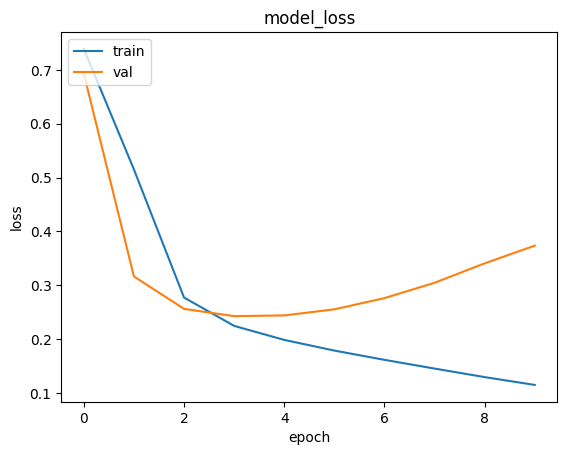

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

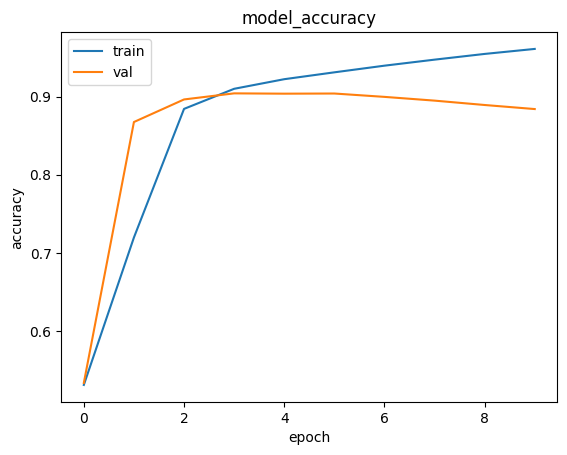

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
transformer.load_weights(checkpoint_filepath)

# Evaluating on test data for transformer

In [ ]:
transformer.evaluate(test_dataset)

313/313 [==============================] - 5s 15ms/step - loss: 0.2425 - accuracy: 0.9042


[0.242487370967865, 0.90420001745224]

In [ ]:
# model prediction
transformer.predict(test_dataset)

313/313 [==============================] - 7s 15ms/step


array([[0.9072335 ],
       [0.9978369 ],
       [0.99702483],
       ...,
       [0.02289296],
       [0.01573818],
       [0.99635005]], dtype=float32)